# Front pages of newspapers -- Initial discovery

We have two datasets:
* `frontpage_texts`, the text boxes extracted from pdfs of the front pages of newspapers, downloaded from the [Newseum](https://newseum.org/todaysfrontpages/)
* `newspapers`, the metadata of the newspapers, also from the Newseum site.

The text boxes contain interesting metadata for a given chunk of text, such as its bounding box, font, and size.

This notebook will document some of the early exploratory attempts to understand the variety of the data, and to move toward performing an analysis of media coverage/bias.

In [1]:
import pandas as pd

df = pd.read_sql_table('frontpage_texts', 'postgres:///frontpages')

In [2]:
df.head()

,text,fontface,fontsize,bbox_left,bbox_bottom,bbox_right,bbox_top,bbox_area,avg_character_area,percent_of_page,page,page_width,page_height,page_area,date,day_of_week,weekend,slug,id
0,"See SAFETY, 2A\n",HHDPCE+HelveticaNeueLTStd-BdCn,10.665,674.70,916.106,729.999,926.771,589.763835,45.072767,0.000536,1,748.0,1472.0,1101056.0,2017-04-12,2,False,CO_DC,190349
1,"CU, CORA\ndisagree\non records\n",HHDPOJ+CenturyStd-BoldCondensed,38.346,594.00,802.122,727.795,904.488,13696.058970,591.161109,0.012439,1,748.0,1472.0,1101056.0,2017-04-12,2,False,CO_DC,190350
2,By Elizabeth Hernandez\nStaff Writer\n,HHDPCA+HelveticaNeueLTStd-Bd,10.140,594.00,779.035,689.477,799.180,1923.384165,42.899610,0.001747,1,748.0,1472.0,1101056.0,2017-04-12,2,False,CO_DC,190351
3,Proponents of a bill intended to\nmake Colorad...,HHDPOD+CenturyOldStyleStd-Regular,11.932,594.00,532.381,730.055,775.305,33051.024820,52.021359,0.030018,1,748.0,1472.0,1101056.0,2017-04-12,2,False,CO_DC,190352
4,"See OPEN RECORDS, 11A\n",HHDPCE+HelveticaNeueLTStd-BdCn,10.665,642.31,519.376,729.997,530.041,935.181855,48.019037,0.000849,1,748.0,1472.0,1101056.0,2017-04-12,2,False,CO_DC,190353


In [3]:
# Some simple cleaning -- remove one character entries, and trailing newlines

df['text'] = df['text'].str.strip()
df = df[df['text'].str.len() > 1]

In [4]:
df_newspapers = pd.read_sql_table('newspapers', 'postgres:///frontpages')

In [5]:
df_newspapers.head()

,city,country,latitude,longitude,slug,state,title,website
0,Anniston,USA,33.696739,-85.823433,AL_AS,AL,The Anniston Star,http://www.annistonstar.com
1,Birmingham,USA,33.518509,-86.804756,AL_BN,AL,The Birmingham News,http://www.al.com/birmingham/
2,Cullman,USA,34.176857,-86.838188,AL_CT,AL,The Cullman Times,http://www.cullmantimes.com
3,Decatur,USA,34.602890,-86.986511,AL_DD,AL,The Decatur Daily,http://www.decaturdaily.com
4,Dothan,USA,31.225517,-85.393631,AL_DE,AL,Dothan Eagle,http://www.dothaneagle.com


In [6]:
us_newspapers_df = df_newspapers[df_newspapers.country == 'USA']
print('''We have metadata for {} newspapers.

There are {} total countries represented. The top 5 are:
{}.

Within the US, there is representation from {} states. The states with the most newspapers are:
{}

And the least:
{}

'''.format(
    df_newspapers.shape[0],
    df_newspapers.country.nunique(),
    df_newspapers.country.value_counts()[:5],
    us_newspapers_df.state.nunique(),
    us_newspapers_df.state.value_counts()[:5],
    us_newspapers_df.state.value_counts()[-5:],
))

We have metadata for 1082 newspapers.

There are 80 total countries represented. The top 5 are:
USA       731
Brazil     60
Canada     41
India      21
Mexico     20
Name: country, dtype: int64.

Within the US, there is representation from 51 states. The states with the most newspapers are:
NY    60
CA    53
PA    44
FL    33
NC    29
Name: state, dtype: int64

And the least:
NV    3
RI    3
AK    3
DE    2
HI    1
Name: state, dtype: int64




In [7]:
df_us = df[df.slug.isin(set(us_newspapers_df.slug))]
newspapers_in_df = df_newspapers[df_newspapers.slug.isin(set(df_us.slug))]

print('''Currently, there are:

{} rows of text
{} days of scrapes
  (earliest: {} 
   latest  : {})
{} total newspapers (not all the pdfs were extractable).

Filtering down to the US, there are now:
{} newspapers
{} rows of text

For those newspapers that are available in the US, there are:
{} states
states with most newspapers:
{}

with least:
{}

with none:
{}
'''.format(
    df.shape[0],
    df.date.nunique(),
    df.date.min(),
    df.date.max(),
    df.slug.nunique(),

    df_us.slug.nunique(),
    df_us.shape[0],
    
    newspapers_in_df.state.nunique(),
    newspapers_in_df.state.value_counts()[:5],
    newspapers_in_df.state.value_counts()[-5:],
    set(df_newspapers.state) - set(newspapers_in_df.state)
))

Currently, there are:

268442 rows of text
14 days of scrapes
  (earliest: 2017-04-01 00:00:00 
   latest  : 2017-04-16 00:00:00)
601 total newspapers (not all the pdfs were extractable).

Filtering down to the US, there are now:
417 newspapers
193969 rows of text

For those newspapers that are available in the US, there are:
50 states
states with most newspapers:
CA    25
PA    24
IN    19
TX    19
FL    18
Name: state, dtype: int64

with least:
DE    2
NE    2
RI    2
NV    1
NH    1
Name: state, dtype: int64

with none:
{'', 'HI'}



# Fonts

In [8]:
print('''Fonts are often written in a format like this: {}.

Out of {} rows...
{} of the fonts have non-empty text
{} of the fonts have a '+'
{} of the fonts have a '-'
'''.format(
    df.fontface.iloc[0],
    df.shape[0],
    (df.fontface.str.len() > 0).sum(),
    df.fontface.str.contains('\+').sum(),
    df.fontface.str.contains('-').sum()
))

Fonts are often written in a format like this: HHDPCE+HelveticaNeueLTStd-BdCn.

Out of 268442 rows...
268442 of the fonts have non-empty text
186893 of the fonts have a '+'
233542 of the fonts have a '-'



In [9]:
print('''This seems to mean that we can break apart the font into:
[optional-leading-thing]+[font-family]-[font-weight]
''')

font_partition = df.fontface.str.rpartition('+')
df['font_family_weight'] = font_partition[2]

font_family_partition = df['font_family_weight'].str.partition('-')

df['font_leading_thing'] = font_partition[0]
df['font_family'] = font_family_partition[0]
df['font_weight'] = font_family_partition[2]

print('''After doing that,
There are...
{} unique font families
{} unique font weights
{} unique optional-leading-things'''.format(
    df.font_family.nunique(),
    df.font_weight.nunique(),
    df.font_leading_thing.nunique()
))

df_us = df[df.slug.isin(set(us_newspapers_df.slug))]

This seems to mean that we can break apart the font into:
[optional-leading-thing]+[font-family]-[font-weight]

After doing that,
There are...
2101 unique font families
1833 unique font weights
32906 unique optional-leading-things


# Denver Post

In [10]:
# Let's do something with a Denver paper

df_newspapers[df_newspapers.city == 'Denver']

,city,country,latitude,longitude,slug,state,title,website
67,Denver,USA,39.741684,-104.987366,CO_DP,CO,The Denver Post,http://www.denverpost.com


In [11]:
import numpy as np

df_denver_post = df_us[df_us.slug == 'CO_DP']

font_stats = df_denver_post.groupby(['font_family_weight']).fontsize.agg({'count': len, 'min': np.min, 'max': np.max, 'avg': np.mean})

print('''We have {} days of scraped Denver Post front pages.

We have {} unique font-weight combos. Here is a mapping of each font family to their min, average, and max font size.

{}
'''.format(
    df_denver_post.date.nunique(),
    df_denver_post.groupby(['font_family_weight']).first().shape[0],
    font_stats
))

We have 12 days of scraped Denver Post front pages.

We have 53 unique font-weight combos. Here is a mapping of each font family to their min, average, and max font size.

                                count     min      max        avg
font_family_weight                                               
Agenda-Bold                       2.0  31.870   31.870  31.870000
AkzidenzGroteskBE-LightEx         1.0   4.354    4.354   4.354000
AkzidenzGroteskBE-MdEx            2.0   6.244   13.537   9.890500
Arial-Black                       2.0  26.410   26.410  26.410000
Arial-BoldItalicMT                2.0   9.469    9.469   9.469000
Avenir-Heavy                      6.0   4.853    4.853   4.853000
AzoSansUber-Regular               2.0  19.680   24.928  22.304000
CastleT-Ultr                      2.0  39.039   39.039  39.039000
DPPiFont                          4.0   8.504    8.504   8.504000
Gotham-Black                      3.0  11.359   17.680  14.132667
Gotham-Bold                       4.

In [12]:
font_days = df_denver_post.groupby(['font_family_weight']).date.nunique().sort_values(ascending=False)

print('''Fonts by number of days on which they appear

{}
'''.format(
    font_days
))

Fonts by number of days on which they appear

font_family_weight
Sun-SemiBold                      12
SunSC-ExtraBold                   12
PoynterOSDisplay-Italic           12
PoynterOSDisplayNarrow-Bold       12
PoynterOSTextThree-Roman          12
SunSC-Regular                     12
Sun-Bold                          12
TheSerifLight-Plain               11
PoynterOSDisplayNarrow-Semibld    10
PoynterOSTextThree-Bold           10
PoynterOSTextThree-Italic         10
PoynterOSTextThree-SemiBld        10
PoynterOSDisplay-Roman             9
PoynterOSDisplay-Bold              9
SunSC-Bold                         7
PoynterOSDisplay-Semibold          7
TheSerifExtraBold-Plain            5
Sun-ExtraBold                      4
DPPiFont                           4
TheSerifBold-Caps                  3
MyriadPro-Regular                  3
MyriadPro-Bold                     2
MyriadPro-It                       2
MyriadPro-SemiboldIt               2
CastleT-Ultr                       2
AzoSansUbe

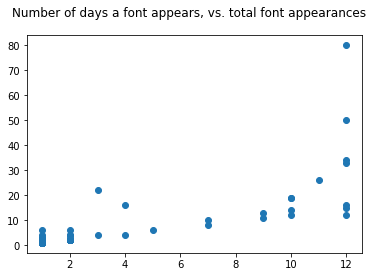

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

font_stats['days_present'] = font_days

plt.suptitle('Number of days a font appears, vs. total font appearances')
plt.scatter(font_stats.days_present, font_stats['count'])

In [14]:
df_denver_post.sort_values(['date', 'avg_character_area'], ascending=False).groupby('date').head(5).head(10)

,text,fontface,fontsize,bbox_left,bbox_bottom,bbox_right,bbox_top,bbox_area,avg_character_area,percent_of_page,...,page_area,date,day_of_week,weekend,slug,id,font_family_weight,font_leading_thing,font_family,font_weight
79644,Running hot and coal,HGLMOI+PoynterOSDisplay-Roman,71.424,191.60,1121.558,712.886,1192.982,37232.331264,2241.201092,0.033815,...,1101056.0,2017-04-16,6,True,CO_DP,269992,PoynterOSDisplay-Roman,HGLMOI,PoynterOSDisplay,Roman
79632,N. Korea\nmissile\nlaunch\na failure,HGLLEM+PoynterOSDisplayNarrow-Bold,40.752,18.00,1027.350,142.956,1176.102,18587.454912,637.966738,0.016881,...,1101056.0,2017-04-16,6,True,CO_DP,269980,PoynterOSDisplayNarrow-Bold,HGLLEM,PoynterOSDisplayNarrow,Bold
79627,DEBATING THE FUTURE\nOF LEGAL MARIJUANA » 1-6D,HGLKPL+Sun-SemiBold,34.432,382.76,1374.210,679.864,1438.642,19143.004928,509.717903,0.017386,...,1101056.0,2017-04-16,6,True,CO_DP,269975,Sun-SemiBold,HGLKPL,Sun,SemiBold
79647,FLORAL TRADITION,HGLMOK+PoynterOSDisplay-Semibold,27.048,191.60,609.376,425.622,636.424,6329.827056,417.750950,0.005749,...,1101056.0,2017-04-16,6,True,CO_DP,269995,PoynterOSDisplay-Semibold,HGLMOK,PoynterOSDisplay,Semibold
79623,M EM B E R S,HGLLBF+TheSerifLight-Plain,22.232,35.40,1440.360,104.252,1462.592,1530.717664,202.666912,0.001390,...,1101056.0,2017-04-16,6,True,CO_DP,269971,TheSerifLight-Plain,HGLLBF,TheSerifLight,Plain
22731,A different path,FDDFNB+PoynterOSDisplay-Roman,89.280,36.48,1157.300,534.640,1246.580,44475.724800,3198.264686,0.040394,...,1101056.0,2017-04-13,3,False,CO_DP,213078,PoynterOSDisplay-Roman,FDDFNB,PoynterOSDisplay,Roman
22681,Denver\nto pay\n$1M for\ndeath,FDDFLK+PoynterOSDisplayNarrow-Bold,50.374,597.20,1058.160,729.815,1242.034,24384.450510,1077.820422,0.022146,...,1101056.0,2017-04-13,3,False,CO_DP,213081,PoynterOSDisplayNarrow-Bold,FDDFLK,PoynterOSDisplayNarrow,Bold
22756,303-900-2926,FDDHLE+Univers-Bold,38.265,498.78,87.241,699.938,125.507,7697.512028,639.485448,0.006991,...,1101056.0,2017-04-13,3,False,CO_DP,213106,Univers-Bold,FDDHLE,Univers,Bold
22725,ROCKIES GET ONLY THREE HITS IN 6-0 LOSS TO PAD...,FDDFIM+Sun-SemiBold,34.432,30.22,1429.810,717.780,1464.242,23674.065920,519.158062,0.021501,...,1101056.0,2017-04-13,3,False,CO_DP,213072,Sun-SemiBold,FDDFIM,Sun,SemiBold
22751,Learn about\nreplacement\nwindows before\nyou ...,FDDHLB+Agenda-Bold,31.870,32.46,37.699,204.481,157.600,20625.489921,430.110672,0.018732,...,1101056.0,2017-04-13,3,False,CO_DP,213101,Agenda-Bold,FDDHLB,Agenda,Bold


# Unigram "percent of page" analysis

Given an unigram like "Syria", how much of a given front page does it occupy? 

### Notes

We will consider the entire text block that contains the unigram to be related to that unigram. For example, the entire headline of "US BOMBS SYRIA" will be counted as space devoted toward "Syria". Likewise, a lengthy front-page article that mentions "Syria" in it will (naively, perhaps) be considered 100% about Syria.

We're assuming that search queries will be proper nouns, so we're not going to perform any stemming or lemmatizing.

### Followup approaches

Some newspapers contain more and smaller text, like the NYT, compared to tabloids where words are written extremely largely across the surface. This may still be of interest -- we do want to acknowledge the space devoted to "Syria" if it is splashed across the front of the tabloid -- but we may also want to develop a measure of relative importance so that a top-of-banner headline is weighted equally across all newspapers.

This approach does not touch on probabilistic topic modeling yet -- these are only direct matches.

We will also want to develop a method to link a headline with an article, so that a headline like "BOOTS ON THE GROUND" could possibly be linked to the followup article on Syria. This would also allow us to do some tangential but interesting accounts of which Associated Press articles get republished the most.

In [15]:
from nltk import word_tokenize

In [16]:
import pprint
import string

chars = set(string.ascii_letters)

def include_word(word):
    return sum([c in chars for c in word]) >= 3

def preprocess_text(text):
    lowered = text.strip().lower()
    lowered = ''.join(lowered.split('-\n'))
    lowered = lowered.replace('\n', ' ')
    words = word_tokenize(lowered)
    filtered_words = [word for word in words if include_word(word)]
    
    return filtered_words

def bag_of_words(text):
    '''Literally, this returns a set of the bag of words for fast single-token searches'''
    return set(preprocess_text(text))

def preprocess_all(texts):
    for text in texts:
        yield text, preprocess_text(text)

print('''For text preprocessing, we consider a few cases:

* Newlines should be stripped
* Everything should be lower-cased
* We should return a tokenized list
* Tokens without a certain number of ascii characters (US-English analysis for now) will be rejected

The extraction from PDFs still contains word-continuations across line breaks.
For now, we'll consider all lines that end with "-" as continuations, and
link the text from before and after.

Newlines without continuations will be replaced with spaces.

Examples:
{}
'''.format(
    pprint.pformat(list(preprocess_all([
        'Hel-\nlo, bye\nnow\n',
         *df_denver_post.text.sample(3)
    ])))
))

For text preprocessing, we consider a few cases:

* Newlines should be stripped
* Everything should be lower-cased
* We should return a tokenized list
* Tokens without a certain number of ascii characters (US-English analysis for now) will be rejected

The extraction from PDFs still contains word-continuations across line breaks.
For now, we'll consider all lines that end with "-" as continuations, and
link the text from before and after.

Newlines without continuations will be replaced with spaces.

Examples:
[('Hel-\nlo, bye\nnow\n', ['hello', 'bye', 'now']),
 ('514,499', []),
 ('Fresh strike\non town hit\nby deadly\nchemicals',
  ['fresh', 'strike', 'town', 'hit', 'deadly', 'chemicals']),
 ('39', [])]



In [17]:
df_us['bow'] = df_us.text.apply(bag_of_words)

/Users/sam/workspace/news/analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
df_denver_post_latest = df_us[(df_us.slug == 'CO_DP') & (df_us.date == df_us.date.max())]

def percent_of_page(unigram, one_paper_df):
    unigram = unigram.lower().strip()
    lines_with_unigram = one_paper_df[one_paper_df.bow.apply(lambda bag: unigram in bag)]
    
    return lines_with_unigram.percent_of_page.sum()

print('''Now we write a method to get the percent of page that a unigram occupies, for a particular front page.

Syria, Denver Post, latest day: {}
garbage input, should be 0: {}'''.format(
    percent_of_page('Syria', df_denver_post_latest),
    percent_of_page('asdflkjasdflasdfkjasdf', df_denver_post_latest)
))

Now we write a method to get the percent of page that a unigram occupies, for a particular front page.

Syria, Denver Post, latest day: 0
garbage input, should be 0: 0


Now we run this method across all the newspapers, across all days!

In [19]:
# filter down to newspapers with entries with more than 3 days
days_of_newspapers = df_us.groupby('slug').date.nunique()

df_us_3plus = df_us[df_us.slug.isin(set(days_of_newspapers[days_of_newspapers > 3].index))]

print('''Number of newspapers with >3 days: {}

(Number of total newspapers: {})
'''.format(
    df_us_3plus.slug.nunique(),
    df_us.slug.nunique()
))

Number of newspapers with >3 days: 341

(Number of total newspapers: 417)



In [20]:
from functools import partial

def unigram_percent_of_page(query, dataframe):
    return dataframe.groupby(['slug', 'date']).apply(partial(percent_of_page, query))

def _reshape_percent_of_day_series(percent_of_page):
    return percent_of_page.reset_index().rename(columns={0: 'percent_of_page'})

def percent_of_page_by_day(percent_of_page_df):
    return _reshape_percent_of_day_series(percent_of_page_df).groupby('date').percent_of_page.mean()

def percent_of_papers_with_mention(percent_of_page_df, threshold=0):
    percents_by_paper_date = _reshape_percent_of_day_series(percent_of_page_df)
    greater_than_thresh = (percents_by_paper_date.groupby(['slug', 'date']).percent_of_page.max() > threshold).reset_index()
    
    return greater_than_thresh.groupby('date').mean()

In [21]:
# Average mentions per day
syria_results = unigram_percent_of_page('Syria', df_us_3plus)

In [22]:
print('''Percent of papers that mentioned Syria by day:
{}

Average percent of newspaper front page devoted to Syria by day:
{}'''.format(
    percent_of_papers_with_mention(syria_results),
    percent_of_page_by_day(syria_results),
))

Percent of papers that mentioned Syria by day:
            percent_of_page
date                       
2017-04-01         0.018727
2017-04-04         0.016667
2017-04-05         0.221854
2017-04-06         0.287313
2017-04-07         0.583039
2017-04-08         0.594142
2017-04-09         0.282609
2017-04-10         0.207469
2017-04-11         0.151515
2017-04-12         0.163194
2017-04-13         0.179389
2017-04-14         0.100719
2017-04-15         0.048000
2017-04-16         0.057778

Average percent of newspaper front page devoted to Syria by day:
date
2017-04-01    0.000591
2017-04-04    0.000518
2017-04-05    0.005230
2017-04-06    0.008735
2017-04-07    0.027946
2017-04-08    0.031311
2017-04-09    0.010841
2017-04-10    0.009895
2017-04-11    0.005084
2017-04-12    0.005361
2017-04-13    0.007252
2017-04-14    0.002086
2017-04-15    0.001283
2017-04-16    0.001010
Name: percent_of_page, dtype: float64


# Connecting newspapers with population metadata

Short of getting data on readership, we'll try to pull population metadata for the hometown of each newspaper.

Edit: See bottom for conclusion. Tldr: it's not great, because there are multiple papers per city, many of which are lesser read. Doh.

In [23]:
df_population = pd.read_csv('~/data/sub-est2015_all.csv', encoding='ISO-8859-2')

In [24]:
df_cities = df_population[df_population.NAME.str.endswith('city') | df_population.NAME.str.endswith('town')]
df_cities['city'] = df_cities.NAME.str.slice(0, -5).str.lower()
df_cities['place_name'] = df_cities.city + ', ' + df_cities.STNAME.str.lower()

df_cities = df_cities.sort_values('POPESTIMATE2015').groupby('place_name').head(1)
df_cities.head()

/Users/sam/workspace/news/analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sam/workspace/news/analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,city,place_name
35950,61,27,103,0,39878,0,0,F,Mankato city,Minnesota,0,0,0,0,0,0,0,0,mankato,"mankato, minnesota"
40886,157,29,137,28000,0,0,1,A,Goss town,Missouri,0,0,0,0,0,0,0,0,goss,"goss, missouri"
81136,61,55,133,0,53000,0,0,F,Milwaukee city,Wisconsin,0,0,0,0,0,0,0,0,milwaukee,"milwaukee, wisconsin"
44352,61,33,9,0,42820,0,1,I,Livermore town,New Hampshire,0,0,0,0,0,0,0,0,livermore,"livermore, new hampshire"
23257,61,20,91,0,7975,0,0,F,Bonner Springs city,Kansas,0,0,0,0,0,0,0,0,bonner springs,"bonner springs, kansas"


In [25]:
state_abbreviation_to_name = {}
with open('files/states.csv') as f:
    next(f) # skip header
    for line in f:
        state, abbrev = line.strip().split(',')
        state_abbreviation_to_name[abbrev.strip('"')] = state.strip('"').lower()

In [26]:
us_newspapers_df['place_name'] = us_newspapers_df.city.str.lower() + ', ' + us_newspapers_df.state.apply(state_abbreviation_to_name.get)

/Users/sam/workspace/news/analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
us_newspapers_with_pop = pd.merge(us_newspapers_df, df_cities[['place_name', 'POPESTIMATE2015']], how='left', on='place_name', copy=False)

In [28]:
print('''{} out of {} newspapers had places found in the census.

Examples of ones that didn't:
{}
'''.format(
    us_newspapers_with_pop.POPESTIMATE2015.count(),
    us_newspapers_with_pop.shape[0],
    us_newspapers_with_pop[us_newspapers_with_pop.POPESTIMATE2015.isnull()].place_name.head()
))

657 out of 731 newspapers had places found in the census.

Examples of ones that didn't:
13         anchorage, alaska
15            juneau, alaska
58       ventura, california
105    the villages, florida
116           macon, georgia
Name: place_name, dtype: object



In [29]:
us_newspapers_df.head()

,city,country,latitude,longitude,slug,state,title,website,place_name
0,Anniston,USA,33.696739,-85.823433,AL_AS,AL,The Anniston Star,http://www.annistonstar.com,"anniston, alabama"
1,Birmingham,USA,33.518509,-86.804756,AL_BN,AL,The Birmingham News,http://www.al.com/birmingham/,"birmingham, alabama"
2,Cullman,USA,34.176857,-86.838188,AL_CT,AL,The Cullman Times,http://www.cullmantimes.com,"cullman, alabama"
3,Decatur,USA,34.602890,-86.986511,AL_DD,AL,The Decatur Daily,http://www.decaturdaily.com,"decatur, alabama"
4,Dothan,USA,31.225517,-85.393631,AL_DE,AL,Dothan Eagle,http://www.dothaneagle.com,"dothan, alabama"


In [30]:
unidentified_map = {}

unidentified_places = us_newspapers_with_pop[us_newspapers_with_pop.POPESTIMATE2015.isnull()]

for i, row in unidentified_places.iterrows():
    matches = (df_population.STNAME == row.state) & (df_population.NAME.str.lower().str.contains(row.city.lower()))
    if matches.sum() == 0:
        continue
        
    pops = df_population[matches].sort_values('POPESTIMATE2015').iloc[0]
    unidentified_map[row.place_name] = (pops.NAME, pops.POPESTIMATE2015)

In [31]:
print('''Out of {} unidentified places, we found {} by looking for substrings.'''.format(
    unidentified_places.shape[0],
    len(unidentified_map)
))

Out of 74 unidentified places, we found 0 by looking for substrings.


Good enough!

In [32]:
import numpy as np

def set_from_map_if_null(row):
    if pd.isnull(row.POPESTIMATE2015):
        return unidentified_map.get(row.place_name, [np.nan, np.nan])[1]
    
    return row.POPESTIMATE2015

us_newspapers_with_pop['population_est_2015'] = us_newspapers_with_pop.apply(set_from_map_if_null, 1)

print('''So now {} out of {} newspapers have populations.

Largest newspapers by population:
{}
'''.format(
    us_newspapers_with_pop.population_est_2015.count(),
    us_newspapers_with_pop.shape[0],
    us_newspapers_with_pop.sort_values('population_est_2015', ascending=False).head(5)[['title', 'state']]
))

So now 657 out of 731 newspapers have populations.

Largest newspapers by population:
                        title state
295        The New York Times    NY
659  Metro - New York Edition    NY
656               AM New York    NY
658        Impacto Latin News    NY
657         Catholic New York    NY



Oof. Looks like population might not work so well, since large cities often have several, lesser-read newspapers.

# Most headline-y words per day

This is a variation on the unigram experiment above, where instead we will compute the percent of page for _all_ words in all newspapers. Then we'll average them together across the newspapers to get the "most headliney words".

A few variations we'll consider:

* We'll run one version where we consider the area given to each word independently, and another one where the bounding box of the entire text box where the word is found is grouped together. In terms of the front page real estate, one approach can be viewed as basically calculating the real estate for individual words, and the other for "topics" where topics consist of all the words in the document.
* There is going to be a lot of noise from stopwords. "The", for instance, will be present in nearly all of the articles. We should perform tf-idf to scale the data first. However, we don't want tf-idf to count newsy words toward the document frequency, so we'll calculate it on a separate corpus first.

In [33]:
# First, without any idf weighting, we'll calculate the contribution of individual words

from collections import Counter

def vocab_weights_by_word(df):
    counter = Counter()
    
    for i, row in df.iterrows():
        for word in row.bow:
            # we won't multiply by the number of characters to get closer to "true" word real estate because we don't
            # care about the length of words. but we will divide by the total area of the page to normalize across
            # newspapers that are different sizes.
            counter[word] += row.avg_character_area 
    
    return counter

sorted(vocab_weights_by_word(df_denver_post_latest).items(), key=lambda x: x[1], reverse=True)[:5]

[('and', 2385.7400418737307),
 ('coal', 2378.2648640964944),
 ('hot', 2241.2010917647),
 ('running', 2241.2010917647),
 ('the', 1337.1773106835635)]

Clearly there needs to be some kind of weighting, or else words like "by" will dominate.

In [34]:
import string
import operator
from collections import Counter

from nltk.corpus import reuters
import numpy as np


doc_freq_counter = Counter()

for fid in reuters.fileids():
    bow = set(map(operator.methodcaller('lower'), reuters.words(fid)))
    bow = bow - set(string.punctuation) - set(string.digits)
    doc_freq_counter.update(bow)

idfs = {}
for word, count in doc_freq_counter.items():
    idfs[word] = np.log(float(len(reuters.fileids())) / count)
    
print('''We'll calculate document frequencies across the {} articles in the Reuters corpus.

The most common words in the corpus are:
{}

As idfs:
{}
'''.format(
    len(reuters.fileids()),
    sorted(doc_freq_counter.items(), key=operator.itemgetter(1), reverse=True)[:5],
    sorted(idfs.items(), key=operator.itemgetter(1))[:5],
))

We'll calculate document frequencies across the 10788 articles in the Reuters corpus.

The most common words in the corpus are:
[('of', 7622), ('the', 6951), ('to', 6944), ('said', 6784), ('and', 6765)]

As idfs:
[('of', 0.34739560282581505), ('the', 0.43954887115913471), ('to', 0.4405564279194345), ('said', 0.46386750678788152), ('and', 0.4666721436547322)]



In [41]:
# again, this time with idf weighting

def vocab_weights_by_word(df, idf=None, method='by_char'):
    '''Methods:
    `by_char`: Average character size of the textbox in which a string is embedded
    `by_word_area`: Average character size * len of string
    `by_block`: Area of block in which string is embedded'''
    if method not in ['by_char', 'by_word_area', 'by_block']:
        raise ArgumentError('method needs to be one of "by_char", "by_word_area", "by_block"')
        
    counter = Counter()
    
    max_idf = max(idf.values()) # used for missing values
    
    for i, row in df.iterrows():
        for word in set(row.bow) - set(string.punctuation) - set(string.digits):
            # we won't multiply by the number of characters to get closer to "true" word real estate because we don't
            # care about the length of words. but we will divide by the total area of the page to normalize across
            # newspapers that are different sizes.
            
            if method in ['by_char', 'by_word_area']:
                weight = row.avg_character_area

                if method == 'by_word_area':
                    weight *= len(word)
            elif method == 'by_block':
                weight = row.percent_of_page
            
            if idf:
                weight *= idf.get(word, max_idf)
                
            counter[word] += weight
            
    
    return counter

print('''The top words in the latest Denver Post by aggregate word "real estate",
weighted by inverse document frequency:
{}

With word areas taken into consideration (longer words get weighted higher):
{}

Using the area of the entire block:
{}

'''.format(
    pprint.pformat(sorted(vocab_weights_by_word(df_denver_post_latest, idfs).items(), key=operator.itemgetter(1), reverse=True)[:10]),
    pprint.pformat(sorted(vocab_weights_by_word(df_denver_post_latest, idfs, method='by_word_area').items(), key=operator.itemgetter(1), reverse=True)[:10]),
    pprint.pformat(sorted(vocab_weights_by_word(df_denver_post_latest, idfs, method='by_block').items(), key=operator.itemgetter(1), reverse=True)[:10])
))

The top words in the latest Denver Post by aggregate word "real estate",
weighted by inverse document frequency:
[('hot', 14598.289587398463),
 ('coal', 12231.546900414951),
 ('running', 11355.453183146501),
 ('debating', 4733.3371356535126),
 ('marijuana', 4733.3371356535126),
 ('floral', 4632.6843716517942),
 ('missile', 3961.990959304801),
 ('launch', 3921.7252721414152),
 ('tradition', 3879.3145661941321),
 ('korea', 3438.5855404812869)]

With word areas taken into consideration (longer words get weighted higher):
[('running', 79488.172282025509),
 ('coal', 48926.187601659803),
 ('hot', 43794.868762195387),
 ('marijuana', 42600.034220881615),
 ('debating', 37866.697085228101),
 ('tradition', 34913.831095747191),
 ('floral', 27796.106229910765),
 ('missile', 27733.936715133605),
 ('launch', 23530.351632848495),
 ('failure', 22874.952740841112)]

Using the area of the entire block:
[('denver', 0.56869727734086761),
 ('coal', 0.47079389655563725),
 ('sevenfold', 0.4393223319727303),
 

# Better document frequencies

The Reuters corpus is only ~10k documents. Instead, let's reverse engineer the document frequencies from the words in a word2vec model of Google News and Zipf's Law.

(Skip to other window, where I did this, and found the results to be lackluster.)

I requested access to the Yahoo News n-grams corpus. Otherwise, may need to be creative.

For now, let's incorporate the document frequencies from the articles themselves in the dataset. The more days we gather, the more we'll be able to do this.

In [36]:
article_word_doc_counts = Counter()

for i, row in df_us.iterrows():
    article_word_doc_counts.update(row.bow)

article_idfs = {}
for word, count in article_word_doc_counts.items():
    article_idfs[word] = np.log(float(df_us.shape[0]) / count)

In [37]:
print('''Vocabulary size of these two different idf datasets:

Reuters: {}
Front pages: {}

Most common front page words:
{}
'''.format(
    len(idfs),
    len(article_idfs),
    pprint.pformat(sorted(article_idfs.items(), key=operator.itemgetter(1))[:10])
))

Vocabulary size of these two different idf datasets:

Reuters: 31046
Front pages: 106215

Most common front page words:
[('the', 1.444091346425928),
 ('and', 1.8025251079432529),
 ('for', 2.0766460363469013),
 ('that', 2.5881162153578186),
 ('with', 2.5939635817934139),
 ('said', 2.7227947287862069),
 ('page', 2.7242083785936058),
 ('see', 2.7408503349043318),
 ('from', 2.8104198698099769),
 ('was', 2.8261342322050069)]



# Finding "front-page-est" words

By combining the results of running all of the newspapers on a given day through the method above, we attempt to find the words most representative of front pages across the country on any particular day.

We'll run it using all three of the different methods we have for weighting words as well.

In [38]:
from sklearn.feature_extraction import DictVectorizer

all_vocab_weights = {}
todays_papers = df_us_3plus[df_us_3plus.date == df_us_3plus.date.max()]
print('Total papers: ', todays_papers.slug.nunique())

for i, (slug, paper) in enumerate(todays_papers.groupby('slug')):
    if i % 50 == 0:
        print('.', end='')
    all_vocab_weights[slug] = vocab_weights_by_word(paper, article_idfs, method='by_word_area')

vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(all_vocab_weights.values())

print('Top results with word area:')
sorted(zip(vectorizer.feature_names_, X.mean(axis=0)), key=operator.itemgetter(1), reverse=True)[:10]

Total papers:  225
.....Top results with word area:


[('easter', 18613.079685581564),
 ('sunday', 10088.005545237518),
 ('happy', 9840.0643489703743),
 ('guguguugggguguguuuggggguguguugguuugggugguggguuguguuuugugguguuuuuuuuuuuuuuuuuuuuuuuuuuuitarrs',
  7560.1167368052365),
 ('the', 5494.2195323558781),
 ('ourourourourourourourourour', 5180.1484222859299),
 ('enquirer', 5138.9624308416396),
 ('advocate', 5088.9972801072263),
 ('jubilation', 4695.557744835517),
 ('bird', 3663.866081493743)]

In [39]:
all_vocab_weights = {}
todays_papers = df_us_3plus[df_us_3plus.date == df_us_3plus.date.max()]
print('Total papers: ', todays_papers.slug.nunique())

for i, (slug, paper) in enumerate(todays_papers.groupby('slug')):
    if i % 50 == 0:
        print('.', end='')
    all_vocab_weights[slug] = vocab_weights_by_word(paper, article_idfs, method='by_char')

vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(all_vocab_weights.values())

print('Top results with character area:')
sorted(zip(vectorizer.feature_names_, X.mean(axis=0)), key=operator.itemgetter(1), reverse=True)[:10]

Total papers:  225
.....Top results with character area:


[('easter', 3102.1799475969301),
 ('happy', 1968.012869794075),
 ('the', 1831.406510785293),
 ('sunday', 1681.3342575395889),
 ('for', 1161.4890319064421),
 ('bird', 915.96652037343574),
 ('and', 848.04174262098059),
 ('day', 839.61806427076419),
 ('trg', 773.49003834668872),
 ('with', 758.62067593992685)]

In [40]:
all_vocab_weights = {}
todays_papers = df_us_3plus[df_us_3plus.date == df_us_3plus.date.max()]
print('Total papers: ', todays_papers.slug.nunique())

for i, (slug, paper) in enumerate(todays_papers.groupby('slug')):
    if i % 50 == 0:
        print('.', end='')
    all_vocab_weights[slug] = vocab_weights_by_word(paper, article_idfs, method='by_block')

vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(all_vocab_weights.values())

print('Top results with block area:')
sorted(zip(vectorizer.feature_names_, X.mean(axis=0)), key=operator.itemgetter(1), reverse=True)[:10]

Total papers:  225
.....Top results with block area:


[('and', 0.2530149956214649),
 ('the', 0.24881876117833573),
 ('for', 0.22261071681588893),
 ('that', 0.21841477964153333),
 ('with', 0.20386716198585889),
 ('said', 0.19573384805281524),
 ('but', 0.17964328527481582),
 ('from', 0.17576985949193535),
 ('was', 0.1698074213670718),
 ('are', 0.16296656858932562)]

Ah! So it looks like:

* all the methods give too much weight to frequency of appearance, vs. rareness of word
* this is especially evident with block area, since every time "the" shows up, the entire area of the block is counted
* the word area weight gives some interesting results but they get skewed by extremely large banners (the enquirer, the advocate, "sunday", etc)

So that means the next steps are:
* remove stopwords
* remove names of newspapers from themselves
* find way to penalize common words even more than idf

# Visualizations

Bringing in the approach from the "Front Page Heatmap" notebook, we can try to visualize the prominence of certain words across front pages today.

In [52]:
df_us_3plus['page_height_round'] = df_us_3plus.page_height.apply(int)
df_us_3plus['page_width_round'] = df_us_3plus.page_width.apply(int)

/Users/sam/workspace/news/analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/sam/workspace/news/analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


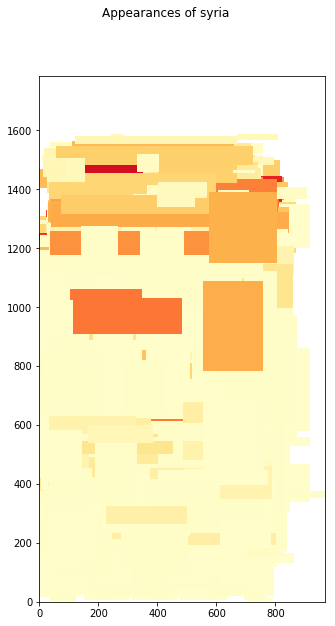

In [55]:
import utils

def plot_word(dataframe, word, date=None, paper=None):
    title = 'Appearances of {}'.format(word)
    if date:
        dataframe = dataframe[dataframe.date == date]
        title += ' on {}'.format(date)
    
    if paper:
        dataframe = dataframe[dataframe.slug == utils.slug_for_newspaper(paper)]
        title += ' on {}'.format(paper)
        
    relevant_df = dataframe[dataframe.bow.apply(lambda bow: word in bow)]
    grids = []
    for (date, slug), paper in relevant_df.groupby(['date', 'slug']):
        grids.append(utils.make_intensity_grid(relevant_df, relevant_df.page_height_round.max(), relevant_df.page_width_round.max()))
    
    avg_intensity = sum([x / len(grids) for x in grids])
    return utils.plot_intensity(avg_intensity, title)

plot_word(df_us_3plus, 'syria')